# 토픽모델링 테스트

In [ ]:
!pip install pyLDAvis
# 위 코드는 Coiab에서는 매번 실행해야 하나
# Jupyter, VSCode 등에서는 터미널에서 한번만 설치하면 진행에 이상 없음

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
import re
from gensim import corpora
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv('train_data.csv')    # 학습모델이 아니므로 많은 데이터 필요X --> 중복제거 잘 되어있는 train_data 선택
print(len(df))
df.head()

2494


,html,label
0,Best Financial Service - #1 shop to ear...,1
1,"bitcoin, bitcoin generator, free bitcoin ...",1
2,Underground Market - Prepaid & Cloned Cards...,1
3,Stolen Cards | Plastic Sharks ...,1
4,Best Amazon Gift Card ...,0


# 전처리

In [ ]:
df = df.drop(columns='label')  # 라벨링 필드는 필요 없으므로 제거
                               # 모델이 자율적으로 알아서 분류(비지도 학습)

In [ ]:
nltk.download('words')
words = set(nltk.corpus.words.words())
ps = PorterStemmer()
processed_html = []
for num in range(len(df['html'])):
  a = df['html'][num]
  sent = re.sub(r'(\dBTC)',' BTC ',a)
  sent_2 = re.sub('[^a-zA-Z]', ' ', sent)   # 임의로 영문자만 출력되는 정규식 작성(숫자 배제)


  #edit = " ".join(w for w in nltk.wordpunct_tokenize(sent_2) \                   # nltk 모듈의 단어사전에 없는 단어들은 배제되게하는 코드였음
  #       if w.lower() in words or not w.isalpha())                               # --> btc, bitcoin, porno 등의 은어들이 전부 배제
                                                                                  # 따라서 주석처리

  edit_2 = " ".join([w for w in sent_2.lower().split() if len(w) > 2])   # 길이가 2이하 단어는 제거(짧은 단어 제거)
  edit_2 = [ps.stem(word) for word in edit_2.lower().split() if not word in set(stopwords.words('english'))]     # PorterStemmer 전처리 기법사용
  edit_2 = ' '.join(edit_2)
  processed_html.append(edit_2)
len(processed_html)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


2494

In [ ]:
# 주석코드 관련 예시
word_vocab = set(w.lower() for w in nltk.corpus.words.words())
'bitcoin' in word_vocab

False

## PorterStemmer 기법 : 단어의 어미부분을 자르는 전처리 기법, 자연어처리에서 주로 많이 쓰임
* 리스크 : 섬세하게 단어의 뜻을 파악하고 자르는 게 아니라 정해진 규칙에 따라서 제거하므로 작업 이후 나오는 결과는 의도와는 다를수도 있음

In [ ]:
# PorterStemmer 예시
from nltk.stem import PorterStemmer
ps = PorterStemmer()
print(ps.stem('saying'))
print(ps.stem('say'))
print(ps.stem('says'))

say
say
say


In [ ]:
df['html'][96]

"    AUTOMATED PAYPAL AND CREDIT CARD MARKET     AUTOMATED PAYPAL AND CREDIT CARD MARKET.  AUTOMATED PAYPAL AND CREDIT CARD MARKET BE AWARE OF SCAMMERS WHO COPY OUR SITE! This is our one and ONLY site - http://4dxawxyzkmo262eefiymmqsw4zl5gg7wbp7wney3mqx6h6i3ux2qaiad.onion Please bookmark us. \xa0 CLICK HERE FOR FEEDBACK PAGE - FEEDBACK SYSTEM. \xa0 We offer: -fresh/new accounts every 2 days     -different balances and prices     -all 100% verified accounts     -free, clean socks5 for every account (in the same country as the holder)     -all accounts have balance     -account replacing if amount is differ than we agreed     -complete step by step walkthrough guide (Easy cash out!)     -cashing out WORLDWIDE in 12h or faster  Last update: Oct 20, 2021    Verified balance PayPal accounts:    Verified balance PayPal accounts: All with 100% verified balance + cashout guide and socks5.    Worldwide PayPal acc + tutorial, socks5    $522 PP ACC / 50$ = 0.00078223BTC $1076 PP ACC / 90$ = 0.001

In [ ]:
processed_html[96]

'autom paypal credit card market autom paypal credit card market autom paypal credit card market awar scammer copi site one site http dxawxyzkmo eefiymmqsw wbp wney mqx qaiad onion pleas bookmark click feedback page feedback system offer fresh new account everi day differ balanc price verifi account free clean sock everi account countri holder account balanc account replac amount differ agre complet step step walkthrough guid easi cash cash worldwid faster last updat oct verifi balanc paypal account verifi balanc paypal account verifi balanc cashout guid sock worldwid paypal acc tutori sock acc btc acc btc acc btc acc btc acc btc acc btc acc btc verifi account balanc check autocheck deliv email reciev acc email pleas provid valid email javascript get account get account info instantli payment pay payment prefer bitcoin payment method construct buy coin http localbitcoin com order select account enter valid email click buy send correct amount bitcoin deposit address confirm approxim min

In [ ]:
stop_words = stopwords.words('english')

In [ ]:
# 동일한 토크나이징 기법으로 html내 단어들을 쪼개줌

from tensorflow.keras.preprocessing.text import text_to_word_sequence
tokenized_doc = []  
for num in range(len(df['html'])):
  word_tokens = text_to_word_sequence(processed_html[num],filters='!"#%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')  
  each_list = []            
  for w in word_tokens:
    if w not in stop_words:   
      each_list.append(w)
  tokenized_doc.append(each_list)     
print(tokenized_doc[96])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
dictionary = corpora.Dictionary(tokenized_doc)          # corpora.Dictionary --> 각 html의 잘라진 단어들을 담은 사전 
print(dictionary[112])
corpus = [dictionary.doc2bow(text) for text in tokenized_doc]           # doc2bow --> 잘라진 단어들에 숫자를 부여

# 모델링(gensim.models.ldamodel.LdaModel)
* 주요 파라미터 : 
* -  num_topics ->  카테고리 개수 지정
* -  id2word=dictionary ->  corpus의 숫자를 dictionary단어에 매칭 후 글자로 표기(시각화에 편리)
* -  passes ->  학습횟수
* 모델 성능검증 :
* -   Coherence 분포(Coherence Model) --> 분류한 카테고리가 의미론적으로 얼마나 일관성있는지 체크(값이 높을수록 좋음)
* -   Coherence 내부의 다양한 지표를 사용하여 검증가능(여기선 가이드라인따라 u_mass 지표사용)

In [ ]:
# 몇개의 카테고리 개수를 지정했을때 Coherence 값이 제일 좋은지 확인
# 2~10까지의 카테고리 개수를 넣고 for문 작동

from gensim.models.coherencemodel import CoherenceModel
start = time.time()
coherence_values = []
for i in range(2,11):
  ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics=i, id2word=dictionary,passes=70)       # passes(학습횟수)에 대해서는 30번부터 60번까지 테스트 --> 40 또는 50번 학습이 제일 적당!
  cm = CoherenceModel(model=ldamodel,corpus=corpus,coherence='u_mass')
  coherence = cm.get_coherence()
  coherence_values.append(coherence)
print('학습소요시간 :',time.time()-start)   # 소요시간 체크

학습소요시간 : 1420.4300549030304


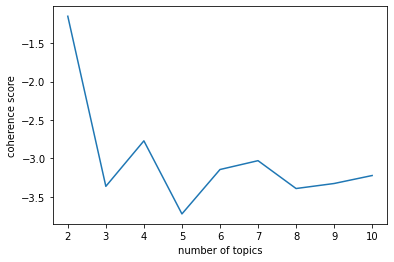

In [ ]:
import matplotlib.pyplot as plt
x = range(2,11)
plt.plot(x,coherence_values)
plt.xlabel('number of topics')
plt.ylabel('coherence score')
plt.show()

# 아래 결과의 단점 : 여러번 돌리면 동일한 모델/파라미터인데도 동일한 결과가 나오지 않는 현상 발생

In [ ]:
# 제일 좋은 설명력을 보이는 카테고리 개수로 지정한 뒤 학습
# 자동화를 위한 코드 작성 필요 --> 가능한가?
import gensim
ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics=7, id2word=dictionary,passes=50)   
topics = ldamodel.print_topics(num_words=10)  # 각 카테고리 별 대표 10개의 단어 추출
for topic in topics:
  print(topic)

# (기여도 * 토큰화된 단어) 들의 합으로 구성되어 있음

(0, '0.013*"url" + 0.011*"linux" + 0.008*"die" + 0.007*"und" + 0.007*"der" + 0.006*"von" + 0.006*"http" + 0.006*"key" + 0.006*"server" + 0.005*"onlin"')
(1, '0.033*"http" + 0.027*"onion" + 0.026*"tor" + 0.014*"que" + 0.014*"org" + 0.010*"user" + 0.010*"year" + 0.009*"www" + 0.008*"reject" + 0.008*"exitpolici"')
(2, '0.007*"new" + 0.007*"post" + 0.006*"video" + 0.006*"read" + 0.004*"time" + 0.004*"like" + 0.004*"web" + 0.004*"one" + 0.004*"use" + 0.004*"news"')
(3, '0.031*"card" + 0.015*"buy" + 0.015*"bitcoin" + 0.013*"use" + 0.010*"get" + 0.009*"payment" + 0.009*"order" + 0.009*"transfer" + 0.008*"money" + 0.008*"account"')
(4, '0.008*"le" + 0.007*"ago" + 0.006*"de" + 0.005*"info" + 0.005*"hour" + 0.005*"pour" + 0.005*"day" + 0.004*"publi" + 0.004*"che" + 0.004*"anon"')
(5, '0.047*"card" + 0.032*"onion" + 0.019*"paypal" + 0.019*"http" + 0.014*"western" + 0.014*"union" + 0.013*"gift" + 0.010*"bitcoin" + 0.010*"credit" + 0.009*"servic"')
(6, '0.055*"usd" + 0.027*"eur" + 0.024*"unit" + 0.

# 시각화
* pyLDAvis : LDA모델 결과를 보여주는 시각화 모듈
* !pip install pyLDAvis   를 통해 설치(설치후 다시 돌려야하는 애로사향 존재)

In [ ]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel,corpus,dictionary)
pyLDAvis.display(vis)

# 원 사이의 거리가 멀수록 독립적인 그룹 / 가까울수록 비슷한 그룹
# 각 카테고리별 대표단어와 이들의 전체 등장 빈도수 대비 얼마나 카테고리 내에서 출현하는지의 비율 표시(하단 Estimated term frequency within the selected topic)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
# 각 문서별 토픽 분포확인
for i, topic_list in enumerate(ldamodel[corpus]) : 
  if i ==5:
    break
  print(i,'번째 문서의 topic 비율은',topic_list)

0 번째 문서의 topic 비율은 [(3, 0.82066524), (5, 0.17810798)]
1 번째 문서의 topic 비율은 [(3, 0.9954735)]
2 번째 문서의 topic 비율은 [(3, 0.6474417), (5, 0.34302577)]
3 번째 문서의 topic 비율은 [(3, 0.99050325)]
4 번째 문서의 topic 비율은 [(3, 0.917209), (5, 0.077717334)]


In [ ]:
# 위 결과를 데이터프레임으로 보기 쉽게하는 함수 생성
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()

    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list            
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)

        for j, (topic_num, prop_topic) in enumerate(doc):
            if j == 0: 
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
            else:
                break
    return(topic_table)

topictable = make_topictable_per_doc(ldamodel,corpus).reset_index()
topictable.columns= ['문서 번호', '가장 비중이 높은 번호','가장 높은 토픽의 비중', '각 토픽의 비중']
topictable[:10]

,문서 번호,가장 비중이 높은 번호,가장 높은 토픽의 비중,각 토픽의 비중
0,0,3.0,0.8207,"[(3, 0.8206642), (5, 0.17810898)]"
1,1,3.0,0.9955,"[(3, 0.9954736)]"
2,2,3.0,0.6474,"[(3, 0.6474265), (5, 0.343041)]"
3,3,3.0,0.9906,"[(3, 0.9905598)]"
4,4,3.0,0.9172,"[(3, 0.917203), (5, 0.07772342)]"
5,5,3.0,0.9756,"[(3, 0.9755805), (5, 0.021863595)]"
6,6,3.0,0.9867,"[(3, 0.9866883), (5, 0.012562915)]"
7,7,3.0,0.6544,"[(3, 0.6544325), (5, 0.0816682), (6, 0.25904682)]"
8,8,3.0,0.7133,"[(0, 0.049872186), (2, 0.08561542), (3, 0.7132..."
9,9,3.0,0.8679,"[(2, 0.07082044), (3, 0.8678664), (5, 0.059412..."


In [ ]:
topictable['가장 비중이 높은 번호'].value_counts()

3.0    1017
2.0     494
5.0     440
0.0     185
1.0     176
6.0     118
4.0      64
Name: 가장 비중이 높은 번호, dtype: int64

In [ ]:
# LDA 모델 평가(현재 학습한 모델)
cm = CoherenceModel(model=ldamodel,corpus=corpus,coherence='u_mass')
coherence = cm.get_coherence()
print('coherence 값 : ', coherence)
print('\nPerplexity 값 : ',ldamodel.log_perplexity(corpus))

coherence 값 :  -3.2070315147879946

Perplexity 값 :  -7.684831904040237


In [ ]:
pd.DataFrame(topictable['가장 비중이 높은 번호']).to_csv('topic_model.csv',index=False)

# 결론
#### 장점 : 
* 1차적으로 카테고리를 분류한다고 가정했을때 성능이 나쁘지 않다
* 동일한 데이터에 대해서 다르게 분류할 가능성이 거의 없다
* 대용량데이터에 대해서는 시험해봐야 알겠지만 학습속도도 나름 괜찮은 편
* 편향된 데이터를 받았을때도 분류성능이 좋다
#### 단점 : 
* 자동화 시키는 코드가 복잡할수도 있다(개인적인 생각)
* 동일한 모델/파라미터를 여러번 넣어도 다른 결과가 나온다
* 각 카테고리가 어떤것인지 사람이 일일이 확인하고 재분류하는 코드를 커스텀해야 한다